# What is the Galactic Metallicity Gradient as a Function of Age?

Investigations on this project thus far have indicated that the radial abundance gradient as a function of stellar age may be a promising diagnostic for nailing down the normalization of $\eta$ with radius, and by extension, the normalization of nucleosynthetic yields as well. In this notebook I use the new [Leung et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023arXiv230205479L/abstract) catalog containing spectroscopic ages to plot the [O/H] and [Fe/H] abundance gradients in bins of stellar age.

In [1]:
from plots.mpltoolkit import named_colors, mpl_loc, markers, fancy_legend, load_mpl_presets
from scipy.stats import bootstrap, skewnorm, linregress
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import math as m
import random
import vice
import sys
load_mpl_presets()
print(sys.version_info)

sys.version_info(major=3, minor=10, micro=2, releaselevel='final', serial=0)


/Users/astrobeard/Work/Research/VICErepos/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [2]:
columns = ["LINE", "APOGEE_ID", "RA", "DEC", "GALR", "GALPHI", "GALZ", "SNREV", "TEFF", "TEFF_ERR",
    "LOGG", "LOGG_ERR", "FE_H", "FE_H_ERR", "O_FE", "O_FE_ERR", "ASTRONN_AGE", "ASTRONN_AGE_ERR",
    "LATENT_AGE", "LATENT_AGE_ERR"]
raw = np.genfromtxt("../data/Leung2023.csv", delimiter = ',', skip_header = 1, usecols = range(len(columns)))
sample = {}
for i in range(len(columns)):
    sample[columns[i]] = [row[i] for row in raw]
sample["o_h"] = [a + b for a, b in zip(sample["O_FE"], sample["FE_H"])]
sample["o_h_err"] = [np.sqrt(a**2 + b**2) for a, b in zip(sample["O_FE_ERR"], sample["FE_H_ERR"])]
sample["absz"] = [abs(_) for _ in sample["GALZ"]]
sample = vice.dataframe(sample)
print(sample)

vice.dataframe{
    line -----------> [0, 1, 2, ... , 192917, 192918, 192919]
    apogee_id ------> [nan, nan, nan, ... , nan, nan, nan]
    ra -------------> [0.00285, 0.005558, 0.008802, ... , 359.993, 359.995, 359.997]
    dec ------------> [57.1732, 57.3545, 63.4631, ... , 57.0124, 57.435, 56.1633]
    galr -----------> [8.4584, 11.9539, 12.8583, ... , 10.6942, 9.3281, 9.64501]
    galphi ---------> [175.658, 153.655, 151.397, ... , 159.022, 167.511, 165.095]
    galz -----------> [-0.040749, -0.470835, 0.169356, ... , -0.358826, -0.163006, -0.265258]
    snrev ----------> [282.746, 120.295, 169.02, ... , 101.537, 232.918, 88.4561]
    teff -----------> [5031.26, 4974.6, 4681.46, ... , 4954.17, 4859.91, 4585.41]
    teff_err -------> [10.1451, 15.3109, 8.76634, ... , 15.7503, 9.05073, 11.2989]
    logg -----------> [3.45613, 2.38825, 2.24553, ... , 2.47466, 2.48069, 2.57144]
    logg_err -------> [0.0235541, 0.0355173, 0.0243345, ... , 0.0347484, 0.0240131, 0.0286862]
    fe_h ----

In [6]:
sub = sample.filter("ASTRONN_AGE", ">=", 0)
print(len(sub["ABSZ"]))
sub = sub.filter("ABSZ", "<=", 0.5)
print(len(sub["ABSZ"]))

191173
96047


In [7]:
# class skewnormal:

#     def __init__(self, a = 0, mean = 0, std = 1):
#         self.a = 0
#         self.mean = mean
#         self.std = std

#     def __call__(self, x):
#         return 1 / self.std * m.sqrt(2 / m.pi) * m.exp(
#             -(x - self.mean)**2 / (2 * self.std**2)
#         ) * (1 + m.erf(self.a * (x - self.mean) / (m.sqrt(2) * self.sigma)))
#         return 1 / self.std * skewnorm((x - self.mean) / self.std, self.a)

def skewnormal(x, a, mean, std):
    return 1 / std * skewnorm.pdf((x - mean) / std, a)

class line:
    
    def __init__(self, slope, intercept):
        self.slope = slope
        self.intercept = intercept
        
    def __call__(self, x):
        return self.slope * x + self.intercept

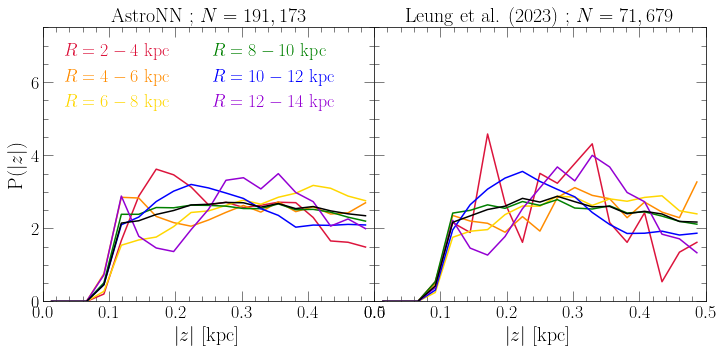

In [9]:
fig = plt.figure(figsize = (10, 5))
axes = []
for i in range(2):
    kwargs = {}
    if i: kwargs["sharey"] = axes[0]
    axes.append(fig.add_subplot(121 + i, **kwargs))
#     axes[i].set_xlabel(r"Age [Gyr]")
    axes[i].set_xlabel(r"$\left|z\right|$ [kpc]")
#     axes[i].set_xlim([0, 12])
#     axes[i].set_ylim([0, 0.40])
#     axes[i].set_xticks(list(range(0, 12 + i, 2)))
    axes[i].set_xlim([0, 0.5])
    axes[i].set_ylim([0, 7.5])
# axes[0].set_ylabel(r"P(Age)")
axes[0].set_ylabel(r"P($\left|z\right|$)")
plt.setp(axes[1].get_yticklabels(), visible = False)

astronn_bins = np.linspace(0, 12, 50)
latent_bins = np.linspace(0, 15, 25)
z_bins = np.linspace(0, 0.5, 20)
radial_bins = [2, 4, 6, 8, 10, 12, 14]
colors = ["crimson", "darkorange", "gold", "green", "blue", "darkviolet"]

for i in range(len(radial_bins) - 1):
    subsample = sample.filter(
        "GALR", ">=", radial_bins[i]).filter(
        "GALR", "<=", radial_bins[i + 1]).filter(
        "ABSZ", ">=", 0.1).filter(
        "ABSZ", "<=", 0.5)
#         "LOGG", ">=", 2.5).filter(
#         "LOGG", "<=", 3.6)
    subsubsample = subsample.filter("ASTRONN_AGE", ">=", 0)
#     dist, _ = np.histogram(subsubsample["ASTRONN_AGE"], bins = astronn_bins, density = True)
    dist, _ = np.histogram(subsubsample["absz"], bins = z_bins, density = True)
    kwargs = {
        "c": named_colors()[colors[i]],
        "label": r"$R = %d - %d$ kpc" % (radial_bins[i], radial_bins[i + 1])
    }
#     centers = [(a + b) / 2 for a, b in zip(astronn_bins[:-1], astronn_bins[1:])]
    centers = [(a + b) / 2 for a, b in zip(z_bins[:-1], z_bins[1:])]
    axes[0].plot(centers, dist, **kwargs)
#     axes[0].step(astronn_bins[:-1], dist, where = "post", **kwargs)
    subsubsample = subsample.filter("LATENT_AGE", ">=", 0)
#     dist, _ = np.histogram(subsubsample["LATENT_AGE"], bins = latent_bins, density = True)
#     centers = [(a + b) / 2 for a, b in zip(latent_bins[:-1], latent_bins[1:])]
    dist, _ = np.histogram(subsubsample["absz"], bins = z_bins, density = True)
    axes[1].plot(centers, dist, **kwargs)

subsample = sample.filter(
    "ASTRONN_AGE", ">=", 0).filter(
    "ABSZ", ">=", 0.1).filter(
    "ABSZ", "<=", 0.5)
# dist, _ = np.histogram(subsample["ASTRONN_AGE"], bins = astronn_bins, density = True)
# centers = [(a + b) / 2 for a, b in zip(astronn_bins[:-1], astronn_bins[1:])]
dist, _ = np.histogram(subsample["absz"], bins = z_bins, density = True)
axes[0].plot(centers, dist, c = named_colors()["black"])
# axes[0].step(astronn_bins[:-1], dist, where = "post", c = named_colors()["black"])

subsample = sample.filter(
    "LATENT_AGE", ">=", 0).filter(
    "ABSZ", ">=", 0.1).filter(
    "ABSZ", "<=", 0.5)
# dist, _ = np.histogram(subsample["LATENT_AGE"], bins = latent_bins, density = True)
# centers = [(a + b) / 2 for a, b in zip(latent_bins[:-1], latent_bins[1:])]
dist, _ = np.histogram(subsample["absz"], bins = z_bins, density = True)
axes[1].plot(centers, dist, c = named_colors()["black"])

# numbers determined by running the lines below, which calculate these values live and set the title
axes[0].set_title(r"AstroNN ; $N = 191,173$", fontsize = 20)
axes[1].set_title(r"Leung et al. (2023) ; $N = 71,679$", fontsize = 20)
# subsample = sample.filter("ASTRONN_AGE", ">=", 0)
# axes[0].set_title(r"AstroNN ; $N = %d$" % (len(subsample["TEFF"])), fontsize = 20)
# subsample = sample.filter("LATENT_AGE", ">=", 0)
# axes[1].set_title(r"Leung et al. (2023) ; $N = %d$" % (len(subsample["TEFF"])), fontsize = 20)

kwargs = {
    "loc": mpl_loc("upper left"),
    "ncol": 2,
    "handlelength": 0
}
leg = axes[0].legend(**kwargs)
fancy_legend(leg, colors)

plt.tight_layout()
plt.subplots_adjust(wspace = 0)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
#     plt.savefig("./apogee/agedists.%s" % (ext), **kwargs)
    plt.savefig("./apogee/abszdists_0p1_0p5.%s" % (ext), **kwargs)
#     plt.savefig("./apogee/agedists_absz_0p1_0p5.%s" % (ext), **kwargs)
plt.show()

In [6]:
astronn_bins = np.linspace(0, 12, 100)
latent_bins = np.linspace(0, 15, 50)
radial_bins = list(range(16))
with open("./astronn_agedist.out", "w") as f_astronn:
    with open("./latent_agedist.out", "w") as f_latent:
        for f in [f_astronn, f_latent]:
            f.write("# r_min [kpc]    r_max [kpc]    ")
            f.write("16th_percentile [Gyr]    median [Gyr]    84th_percentile [Gyr]\n")
#             f.write("a    err_a    ")
#             f.write("mean [Gyr]    err_mean [Gyr]    ")
#             f.write("std [Gyr]    err_std[Gyr]\n")
        for i in range(len(radial_bins) - 1):
            sys.stdout.write("\rR = %d - %d kpc      " % (radial_bins[i], radial_bins[i + 1]))
            subsample = sample.filter(
                "GALR", ">=", radial_bins[i]).filter(
                "GALR", "<=", radial_bins[i + 1]).filter(
                "GALZ", ">=", -0.5).filter(
                "GALZ", "<=", 0.5)
            subsubsample = subsample.filter("ASTRONN_AGE", ">=", 0)
            f_astronn.write("%.3e\t%.3e\t" % (radial_bins[i], radial_bins[i + 1]))
            if len(subsubsample["ASTRONN_AGE"]) >= 200:
                median = np.median(subsubsample["ASTRONN_AGE"])
                sorted_ages = np.sort(subsubsample["ASTRONN_AGE"])
                lower = sorted_ages[int(0.16 * len(sorted_ages))]
                upper = sorted_ages[int(0.84 * len(sorted_ages))]
                f_astronn.write("%.3e\t%.3e\t%.3e\n" % (lower, median, upper))
            else:
                f_astronn.write("nan\tnan\tnan\n")
#             if len(subsubsample["ASTRONN_AGE"]) >= 2 * len(astronn_bins):
#                 centers = [(a + b) / 2 for a, b in zip(astronn_bins[:-1], astronn_bins[1:])]
#                 dist, _ = np.histogram(subsubsample["ASTRONN_AGE"], bins = astronn_bins, density = True)
#                 opt, cov = curve_fit(skewnormal, centers, dist)
#                 errs = np.sqrt(np.diag(cov))
#                 f_astronn.write("%.3e\t%.3e\t%.3e\t%.3e\t%.3e\t%.3e\n" % (
#                     opt[0], errs[0], opt[1], errs[1], opt[2], errs[2]))
#             else:
#                 f_astronn.write("nan\tnan\tnan\n")
            subsubsample = subsample.filter("LATENT_AGE", ">=", 0)
            f_latent.write("%.3e\t%.3e\t" % (radial_bins[i], radial_bins[i + 1]))
            if len(subsubsample["LATENT_AGE"]) >= 200:
                median = np.median(subsubsample["LATENT_AGE"])
                sorted_ages = np.sort(subsubsample["LATENT_AGE"])
                lower = sorted_ages[int(0.16 * len(sorted_ages))]
                upper = sorted_ages[int(0.84 * len(sorted_ages))]
                f_latent.write("%.3e\t%.3e\t%.3e\n" % (lower, median, upper))
            else:
                f_latent.write("nan\tnan\tnan\n")
#             if len(subsubsample["LATENT_AGE"]) >= 2 * len(latent_bins):
#                 centers = [(a + b) / 2 for a, b in zip(latent_bins[:-1], latent_bins[1:])]
#                 dist, _ = np.histogram(subsubsample["LATENT_AGE"], bins = latent_bins, density = True)
#                 opt, cov = curve_fit(skewnormal, centers, dist)
#                 errs = np.sqrt(np.diag(cov))
#                 f_latent.write("%.3e\t%.3e\t%.3e\t%.3e\t%.3e\t%.3e\n" %(
#                      opt[0], errs[0], opt[1], errs[1], opt[2], errs[2]))
#             else:
#                 f_latent.write("nan\tnan\tnan\n")
        f_latent.close()
    f_astronn.close()
sys.stdout.write("\n")

R = 14 - 15 kpc      


1

./astronn_agedist.out
slope: -0.360 +/- 0.040
intercept: 8.841 +/- 0.343
r^2: 0.864
p: 5.328e-07
./latent_agedist.out
slope: -0.439 +/- 0.048
intercept: 8.599 +/- 0.439
r^2: 0.902
p: 7.969e-06


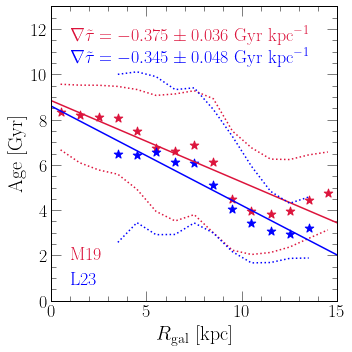

In [8]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$R_\text{gal}$ [kpc]")
ax.set_ylabel(r"Age [Gyr]")
ax.set_xlim([0, 15])
ax.set_ylim([0, 13])

def plot_dist(filename, **additional_kwargs):
    raw = np.genfromtxt(filename)
    radii = [(a + b) / 2 for a, b in zip([row[0] for row in raw], [row[1] for row in raw])]
    lower = [row[2] for row in raw]
    medians = [row[3] for row in raw]
    upper = [row[4] for row in raw]
    fitdata = []
    for i in range(len(medians)):
        if medians[i] > 0: fitdata.append([radii[i], medians[i]])
    regression = linregress(fitdata)
    print(filename)
    print("slope: %.3f +/- %.3f" % (regression.slope, regression.stderr))
    print("intercept: %.3f +/- %.3f" % (regression.intercept, regression.intercept_stderr))
    print("r^2: %.3f" % (regression.rvalue**2))
    print("p: %.3e" % (regression.pvalue))
    print("========================================")
    kwargs = {
        "marker": markers()["star"],
        "s": 80
    }
    for key in additional_kwargs.keys(): kwargs[key] = additional_kwargs[key]
    ax.scatter(radii, medians, **kwargs)
    fit = line(regression.slope, regression.intercept)
    kwargs = {
        "linestyle": '-'
    }
    for key in additional_kwargs.keys():
        if key == "label": continue
        kwargs[key] = additional_kwargs[key]
    ax.plot(ax.get_xlim(), [fit(r) for r in ax.get_xlim()], **kwargs)
    kwargs["linestyle"] = ':'
    kwargs["label"] = None
    kwargs["marker"] = None
    if "s" in kwargs.keys(): del kwargs["s"]
    ax.plot(radii, lower, **kwargs)
    ax.plot(radii, upper, **kwargs)

kwargs = {
    "c": named_colors()["crimson"],
    "label": "M19"
#     "label": r"$\nabla\tau = -0.36 \pm 0.04$ Gyr kpc$^{-1}$"
}

plot_dist("./astronn_agedist.out", **kwargs)
kwargs["c"] = named_colors()["blue"]
kwargs["label"] = "L23"
# kwargs["label"] = r"$\nabla\tau = -0.44 \pm 0.05$ Gyr kpc$^{-1}$"
plot_dist("./latent_agedist.out", **kwargs)

ax.text(1, 11.5, r"$\nabla\tilde{\tau} = -0.375 \pm 0.036$ Gyr kpc$^{-1}$",
    c = named_colors()["crimson"], fontsize = 18)
ax.text(1, 10.5, r"$\nabla\tilde{\tau} = -0.345 \pm 0.048$ Gyr kpc$^{-1}$",
    c = named_colors()["blue"], fontsize = 18)

kwargs = {
    "loc": mpl_loc("lower left"),
    "bbox_to_anchor": (-0.01, -0.01),
    "handlelength": 0
}
leg = ax.legend(**kwargs)
fancy_legend(leg, ["crimson", "blue"])

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./apogee/age_gradient.%s" % (ext), **kwargs)
plt.show()

age = 0 - 2 Gyr ; N = 16045
age = 2 - 4 Gyr ; N = 40784
age = 4 - 6 Gyr ; N = 43275
age = 6 - 8 Gyr ; N = 44409
age = 8 - 10 Gyr ; N = 40354


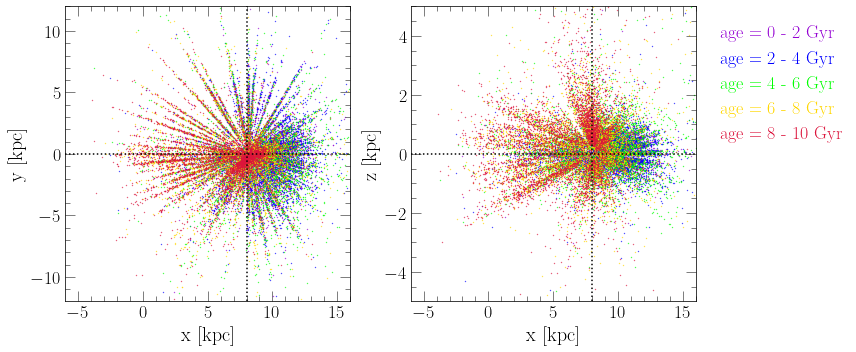

In [4]:
N_SAMPLE = 5000
random.seed(a = 1)

fig = plt.figure(figsize = (12, 5))
axes = []
for i in range(2): axes.append(fig.add_subplot(121 + i))
axes[0].set_xlabel("x [kpc]")
axes[0].set_ylabel("y [kpc]")
axes[0].set_xlim([-6, 16])
axes[0].set_ylim([-12, 12])
axes[1].set_xlabel("x [kpc]")
axes[1].set_ylabel("z [kpc]")
axes[1].set_xlim([-6, 16])
axes[1].set_ylim([-5, 5])

age_bins = [0, 2, 4, 6, 8, 10]
colors = ["darkviolet", "blue", "lime", "gold", "crimson"]
for i in range(len(colors)):
    subsample = sample.filter("ASTRONN_AGE", ">=", age_bins[i]).filter("ASTRONN_AGE", "<=", age_bins[i + 1])
    print("age = %g - %g Gyr ; N = %d" % (age_bins[i], age_bins[i + 1], len(subsample["TEFF"])))
    indeces = random.sample(range(len(subsample["TEFF"])), N_SAMPLE)
    kwargs = {
        "c": named_colors()[colors[i]],
        "s": 0.1,
        "rasterized": True,
        "label": "age = %d - %d Gyr" % (age_bins[i], age_bins[i + 1])
    }
    x = N_SAMPLE * [0.]
    y = N_SAMPLE * [0.]
    z = N_SAMPLE * [0.]
    for i in range(N_SAMPLE):
        x[i] = -subsample["GALR"][indeces[i]] * np.cos(np.pi / 180 * subsample["GALPHI"][indeces[i]])
        y[i] = -subsample["GALR"][indeces[i]] * np.sin(np.pi / 180 * subsample["GALPHI"][indeces[i]])
        z[i] = subsample["GALZ"][indeces[i]]
    axes[0].scatter(x, y, **kwargs)
    axes[1].scatter(x, z, **kwargs)

kwargs = {
    "c": named_colors()["black"],
    "linestyle": ":"
}
axes[0].axhline(0, **kwargs)
axes[0].axvline(8, **kwargs)
axes[1].axhline(0, **kwargs)
axes[1].axvline(8, **kwargs)

kwargs = {
    "loc": mpl_loc("upper left"),
    "bbox_to_anchor": (1.01, 0.99),
    "handlelength": 0
}
leg = axes[1].legend(**kwargs)
fancy_legend(leg, colors)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./apogee/spatial_distribution.%s" % (ext), **kwargs)
plt.show()

## The Spatial Distribution of the Sample

Above is a plot showing x-y and x-z projections of the sample in Galactocentric coordinates. There are 5,000 randomly sampled stars plotted from each age bin, with cool (warm) colors showing young (old) stellar populations. It is visually apparent that the younger stellar populations dominate at larger radii and smaller midplane distances, and conversely, older populations dominate closer to the Galactic center but farther from the midplane.

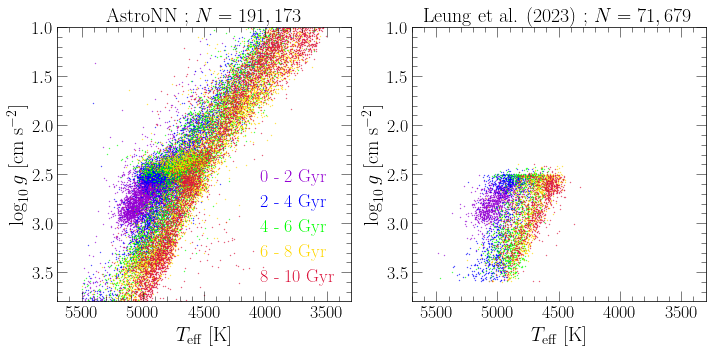

In [19]:
# N_SAMPLE = 2000
N_SAMPLE_ASTRONN = 5000
N_SAMPLE_LATENT = 1000
random.seed(a = 1)

fig = plt.figure(figsize = (10, 5))
axes = []
for i in range(2):
    kwargs = {}
    if i: kwargs["sharey"] = axes[0]
    axes.append(fig.add_subplot(121 + i, **kwargs))
    axes[i].set_xlabel(r"$T_\text{eff}$ [K]")
    axes[i].set_ylabel(r"$\log_{10} g$ [cm s$^{-2}$]")
    axes[i].set_xlim([3300, 5700])
    axes[i].set_ylim([1, 3.8])
    axes[i].invert_xaxis()
    axes[i].invert_yaxis()
# ax = fig.add_subplot(111)
# ax.set_xlabel(r"$T_\text{eff}$ [K]")
# ax.set_ylabel(r"$\log_{10} g$ [cm s$^{-2}$]")
# ax.set_xlim([3300, 5700])
# ax.set_ylim([1, 3.8])
# ax.invert_xaxis()
# ax.invert_yaxis()
axes[0].set_title(r"AstroNN ; $N = 191,173$", fontsize = 20)
axes[1].set_title(r"Leung et al. (2023) ; $N = 71,679$", fontsize = 20)

age_bins = [0, 2, 4, 6, 8, 10]
colors = ["darkviolet", "blue", "lime", "gold", "crimson"]
for i in range(len(colors)):
    subsample = sample.filter(
        "ASTRONN_AGE", ">=", age_bins[i]).filter(
        "ASTRONN_AGE", "<=", age_bins[i + 1]).filter(
        "ABSZ", ">=", 0.1).filter(
        "ABSZ", "<=", 0.5)
    indices = random.sample(range(len(subsample["TEFF"])), N_SAMPLE_ASTRONN)
    kwargs = {
        "c": named_colors()[colors[i]],
        "s": 0.1,
        "rasterized": True,
        "label": "%d - %d Gyr" % (age_bins[i], age_bins[i + 1])
    }
    teff = [subsample["TEFF"][idx] for idx in indices]
    logg = [subsample["LOGG"][idx] for idx in indices]
    axes[0].scatter(teff, logg, **kwargs)
    subsample = sample.filter(
        "LATENT_AGE", ">=", age_bins[i]).filter(
        "LATENT_AGE", "<=", age_bins[i + 1]).filter(
        "ABSZ", ">=", 0.1).filter(
        "ABSZ", "<=", 0.5)
    indices = random.sample(range(len(subsample["TEFF"])), N_SAMPLE_LATENT)
    teff = [subsample["TEFF"][idx] for idx in indices]
    logg = [subsample["LOGG"][idx] for idx in indices]
    axes[1].scatter(teff, logg, **kwargs)
    
kwargs = {
    "loc": mpl_loc("lower right"),
    "ncol": 1,
    "handlelength": 0
}
leg = axes[0].legend(**kwargs)
fancy_legend(leg, colors)
    
plt.tight_layout()
# for ext in ["pdf", "jpeg"]:
#     kwargs = {}
#     if ext == "jpeg": kwargs["dpi"] = 200
#     plt.savefig("./apogee/kiel_diagram.%s" % (ext), **kwargs)
plt.show()

## The Kiel Diagram of the Sample

This figure shows a Kiel diagram of our sample with 5,000 stars randomly selected from each age bin. Cool (warm) colors show young (old) stellar populations. In general, younger stellar populations are more clustered around the red clump at $\log g \approx 2.5$, while older populations sample the red giant branch more uniformly.

/home/johnson.7419/tmp/ipykernel_6659/1265979643.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


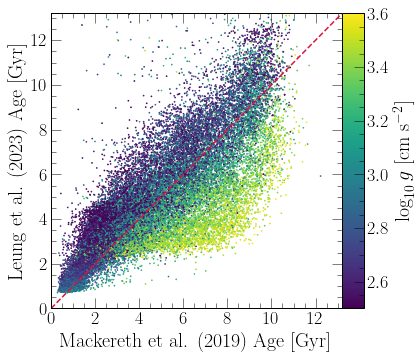

In [4]:
colormap = "viridis"

fig = plt.figure(figsize = (6, 5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Mackereth et al. (2019) Age [Gyr]")
ax.set_ylabel(r"Leung et al. (2023) Age [Gyr]")
ax.set_xlim([0, 13.2])
ax.set_ylim([0, 13.2])
ax.set_xticks(ax.get_yticks()[:-1])

subsample = sample.filter(
    "LATENT_AGE", ">=", 0).filter(
    "ASTRONN_AGE", ">=", 0).filter(
    "ABSZ", ">=", 0.1).filter(
    "ABSZ", "<=", 0.5)
kwargs = {
    "s": 0.5,
    "c": subsample["logg"],
    "cmap": plt.get_cmap("viridis"),
    "vmin": 2.5,
    "vmax": 3.6,
    "rasterized": True
}
sc = ax.scatter(subsample["ASTRONN_AGE"], subsample["LATENT_AGE"], **kwargs)
cbar_ax = fig.add_axes([0.92, 0.05, 0.05, 0.95])
cbar = plt.colorbar(mappable = sc, cax = cbar_ax, orientation = "vertical")
cbar.set_label(r"$\log_{10} g$ [cm s$^{-2}$]")

kwargs = {
    "c": named_colors()["crimson"],
    "linestyle": "--"
}
ax.plot(ax.get_xlim(), ax.get_ylim(), **kwargs)

plt.tight_layout()
plt.subplots_adjust(right = 0.8)
cbar_ax.set_position([
    ax.get_position().x1,
    ax.get_position().y0,
    0.05,
    ax.get_position().y1 - ax.get_position().y0
])
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./apogee/age_comparison_logg_systematics.%s" % (ext), **kwargs)
plt.show()

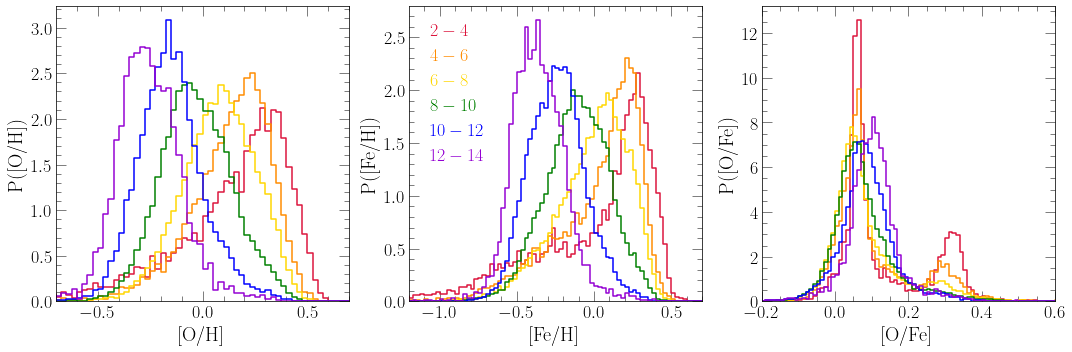

In [11]:
fig = plt.figure(figsize = (15, 5))
labels = ["[O/H]", "[Fe/H]", "[O/Fe]"]
keys = ["O_H", "FE_H", "O_FE"]
axes = []
for i in range(3):
    axes.append(fig.add_subplot(131 + i))
    axes[i].set_xlabel(labels[i])
    axes[i].set_ylabel("P(%s)" % (labels[i]))
axes[0].set_xlim([-0.7, 0.7])
axes[1].set_xlim([-1.2, 0.7])
axes[2].set_xlim([-0.2, 0.6])
    
xh_bins = np.linspace(-3, 2, 201)
ofe_bins = np.linspace(-3, 2, 501)
radial_bins = [2, 4, 6, 8, 10, 12, 14]
colors = ["crimson", "darkorange", "gold", "green", "blue", "darkviolet"]
for i in range(len(radial_bins) - 1):
    subsample = sample.filter(
        "GALR", ">=", radial_bins[i]).filter(
        "GALR", "<=", radial_bins[i + 1]).filter(
        "GALZ", ">=", -0.5).filter(
        "GALZ", "<=", 0.5).filter(
        "ASTRONN_AGE", ">=", 0)
    kwargs = {
        "c": named_colors()[colors[i]],
        "label": r"$%d - %d$" % (radial_bins[i], radial_bins[i + 1])
    }
    for j in range(len(keys)):
        if keys[j] == "O_FE":
            bins = ofe_bins
        else:
            bins = xh_bins
        dist, _ = np.histogram(subsample[keys[j]], bins = bins, density = True)
        axes[j].step(bins[:-1], dist, where = "post", **kwargs)
        
kwargs = {
    "loc": mpl_loc("upper left"),
    "handlelength": 0
}
leg = axes[1].legend(**kwargs)
fancy_legend(leg, colors)
        
for i in range(len(axes)): axes[i].set_ylim([0, axes[i].get_ylim()[1]])
plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./apogee/mdfs.%s" % (ext), **kwargs)
plt.show()

**The Mode of a Skew-Normal Distribution**

The mode of a skewnormal distribution can be determined by optimizing its PDF, but there is no analytic solution. Azzalini & Capitanio (2014) show that an accurate numerical approximation is given by $\mu + \sigma m_0$ for mean $\mu$ and standard deviation $\sigma$, where $m_0$ is given by

$$
m_0 = \sqrt{\frac{2}{\pi}}
\left[\delta - \left(\frac{4 - \pi}{2}\right)\frac{\delta^3}{\pi - 2\delta^2}\right] -
\frac{\text{sign}(a)}{2} e^{-2\pi / \left|a\right|}.
$$

In the above expression, $a$ is the skewness parameter and $\delta \equiv a / \sqrt{1 + a^2}$. Below is a BibTeX entry for Azzalini & Capitanio (2014):

@BOOK{Azzalini2014,
author = {{Azzalini}, Adelchi and {Capitanio}, Antonella},
year = 2014,
month = jan,
title = {The Skew-Normal and Related Families},
isbn = {9781107029279},
doi = {10.1017/CBO9781139248891}
}

In [4]:
def mode_of_skewnorm(a, mean, std):
    delta = a / np.sqrt(1 + a**2)
    term1 = (4 - np.pi) / 2 * delta**3 / (np.pi - 2 * delta**2)
    sgn = int(a > 0) - int(a < 0)
    factor = np.sqrt(2 / np.pi) * (delta - term1) - sgn / 2 * np.exp(-2 * np.pi / abs(a))
    return mean + std * factor

In [15]:
radial_bins = list(range(16))
bins = np.linspace(-3, 2, 1001)
with open("./oh_gradient_fit.out", 'w') as f:
    f.write("# r_min [kpc]    r_max [kpc]    16th_percentile_oh    mode_oh    84th_percentile_oh    ")
    f.write("16th_percentile_feh    mode_feh    84th_percentile_feh\n")
    for i in range(len(radial_bins) - 1):
        sys.stdout.write("\rR = %d - %d kpc     " % (radial_bins[i], radial_bins[i + 1]))
        subsample = sample.filter(
            "GALR", ">=", radial_bins[i]).filter(
            "GALR", "<=", radial_bins[i + 1]).filter(
            "GALZ", ">=", -0.5).filter(
            "GALZ", "<=", 0.5)
        f.write("%.3e\t%.3e\t" % (radial_bins[i], radial_bins[i + 1]))
        if len(subsample["O_H"]) >= 200:
            dist, _ = np.histogram(subsample["O_H"], bins = bins, density = True)
            centers = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
            opt, cov = curve_fit(skewnormal, centers, dist, p0 = [1, 0, 1])
            mode = mode_of_skewnorm(opt[0], opt[1], opt[2])
    #         idxmax = dist.tolist().index(max(dist))
    #         mode = (bins[idxmax] + bins[idxmax + 1]) / 2
            sorted_oh = np.sort(subsample["O_H"])
            lower = sorted_oh[int(0.16 * len(sorted_oh))]
            upper = sorted_oh[int(0.84 * len(sorted_oh))]
#             if upper < lower: print("hello!")
#             print("%d-%d kpc   %.3f    %.3f    %.3f" % (radial_bins[i], radial_bins[i + 1], lower, mode, upper))
            f.write("%.3e\t%.3e\t%.3e\t" % (lower, mode, upper))
        else:
            f.write("nan\tnan\tnan\t")
        if len(subsample["FE_H"]) >= 200:
            dist, _ = np.histogram(subsample["FE_H"], bins = bins, density = True)
            centers = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
            opt, cov = curve_fit(skewnormal, centers, dist, p0 = [1, 0, 1])
            mode = mode_of_skewnorm(opt[0], opt[1], opt[2])
            sorted_feh = np.sort(subsample["FE_H"])
            lower = sorted_feh[int(0.16 * len(sorted_feh))]
            upper = sorted_feh[int(0.84 * len(sorted_feh))]
            f.write("%.3e\t%.3e\t%.3e\t" % (lower, mode, upper))
        else:
            f.write("nan\tnan\tnan\t")
        f.write("\n")
    f.close()
sys.stdout.write("\n")

R = 14 - 15 kpc     


1

slope: -0.062 +/- 0.001
intercept: 0.524 +/- 0.013
r^2: 0.993
p: 3.191e-15


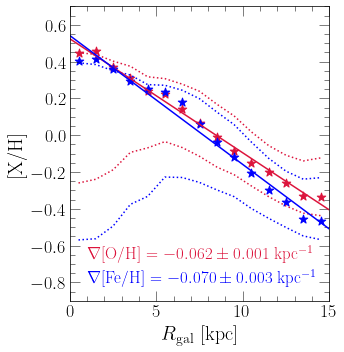

In [34]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$R_\text{gal}$ [kpc]")
ax.set_ylabel("[X/H]")
ax.set_xlim([0, 15])
ax.set_ylim([-0.9, 0.7])

raw = np.genfromtxt("./oh_gradient_fit.out")
radii = [(a + b) / 2 for a, b in zip([row[0] for row in raw], [row[1] for row in raw])]
oh_lower = [row[2] for row in raw]
oh = [row[3] for row in raw]
oh_upper = [row[4] for row in raw]
feh_lower = [row[5] for row in raw]
feh = [row[6] for row in raw]
feh_upper = [row[7] for row in raw]

kwargs = {
    "c": named_colors()["crimson"],
    "marker": markers()["star"],
    "s": 80
}
ax.scatter(radii, oh, **kwargs)
kwargs["c"] = named_colors()["blue"]
ax.scatter(radii, feh, **kwargs)

kwargs = {
    "c": named_colors()["crimson"],
    "linestyle": ":"
}
ax.plot(radii, oh_lower, **kwargs)
ax.plot(radii, oh_upper, **kwargs)
kwargs["c"] = named_colors()["blue"]
ax.plot(radii, feh_lower, **kwargs)
ax.plot(radii, feh_upper, **kwargs)

kwargs["linestyle"] = '-'
kwargs["c"] = named_colors()["crimson"]
regression = linregress(radii, oh)
print("slope: %.3f +/- %.3f" % (regression.slope, regression.stderr))
print("intercept: %.3f +/- %.3f" % (regression.intercept, regression.intercept_stderr))
print("r^2: %.3f" % (regression.rvalue**2))
print("p: %.3e" % (regression.pvalue))
bestfit = line(regression.slope, regression.intercept)
ax.plot(ax.get_xlim(), [bestfit(_) for _ in ax.get_xlim()], **kwargs)
ax.text(1, -0.67, r"$\nabla$[O/H] $= %.3f \pm %.3f$ kpc$^{-1}$" % (
    regression.slope, regression.stderr), fontsize = 17, c = named_colors()["crimson"])

kwargs["c"] = named_colors()["blue"]
regression = linregress(radii, feh)
bestfit = line(regression.slope, regression.intercept)
ax.plot(ax.get_xlim(), [bestfit(_) for _ in ax.get_xlim()], **kwargs)
ax.text(1, -0.8, r"$\nabla$[Fe/H] $= %.3f \pm %.3f$ kpc$^{-1}$" % (
    regression.slope, regression.stderr), fontsize = 17, c = named_colors()["blue"])

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./apogee/xh_gradient.%s" % (ext), **kwargs)
plt.show()

In [10]:
age_bins = [0, 2, 4, 6, 8, 10]
radial_bins = list(range(16))
# colors = ["darkviolet", "blue", "lime", "gold", "crimson"]
with open("./apogee/age_gradoh_skewnormfits.out", "w") as f_oh:
    with open("./apogee/age_gradfeh_skewnormfits.out", "w") as f_fe:
        for f in [f_oh, f_fe]:
            f.write("# Columns:\n")
            f.write("# 0. age_min [Gyr]\n")
            f.write("# 1. age_max [Gyr]\n")
            f.write("# 2. r_min [kpc]\n")
            f.write("# 3. r_max [kpc]\n")
            f.write("# 4. a\n")
            f.write("# 5. err_a\n")
            f.write("# 6. mu\n")
            f.write("# 7. err_mu\n")
            f.write("# 8. std\n")
            f.write("# 9. err_std\n")
        for i in range(len(age_bins) - 1):
            subsample = sample.filter(
                "ASTRONN_AGE", ">=", age_bins[i]).filter(
                "ASTRONN_AGE", "<=", age_bins[i + 1]).filter(
#                 "LATENT_AGE", ">=", age_bins[i]).filter(
#                 "LATENT_AGE", "<=", age_bins[i + 1]).filter(
                "GALZ", ">=", -0.5).filter(
                "GALZ", "<=", 0.5).filter(
                "O_H", ">=", -10).filter(
                "O_H", "<=", 10).filter(
                "FE_H", ">=", -10).filter(
                "FE_H", "<=", 10)
            for j in range(len(radial_bins) - 1):
                for f in [f_oh, f_fe]: f.write("%.3e\t%.3e\t" % (age_bins[i], age_bins[i + 1]))
                for f in [f_oh, f_fe]: f.write("%.3e\t%.3e\t" % (radial_bins[j], radial_bins[j + 1]))
                sys.stdout.write("\rage = %d - %d Gyr ; R = %d - %d kpc       " % (
                    age_bins[i], age_bins[i + 1], radial_bins[j], radial_bins[j + 1]))
                subsubsample = subsample.filter(
                    "GALR", ">=", radial_bins[j]).filter(
                    "GALR", "<=", radial_bins[j + 1])
                if len(subsubsample["O_H"]) >= 200:
                    dist, bins = np.histogram(subsubsample["O_H"], bins = 1000, density = True)
                    centers = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
                    opt, cov = curve_fit(skewnormal, centers, dist)
                    errs = np.sqrt(np.diag(cov))
                    for i in range(len(opt)): f_oh.write("%.3e\t%.3e\t" % (opt[i], errs[i]))
                    f_oh.write("\n")
                else:
                    f_oh.write("nan\tnan\tnan\tnan\tnan\tnan\n")
                if len(subsubsample["FE_H"]) >= 200:
                    dist, bins = np.histogram(subsubsample["FE_H"], bins = 1000, density = True)
                    centers = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
                    opt, cov = curve_fit(skewnormal, centers, dist)
                    errs = np.sqrt(np.diag(cov))
                    for i in range(3): f_fe.write("%.3e\t%.3e\t" % (opt[i], errs[i]))
                    f_fe.write("\n")
                else:
                    f_fe.write("nan\tnan\tnan\tnan\tnan\tnan\n")
        sys.stdout.write("\n")
        f.close()

age = 4 - 6 Gyr ; R = 14 - 15 kpc       


Age: 0 - 2 Gyr
Slope: -0.051 +/- 0.007
Intercept: 0.441 +/- 0.066
Age: 2 - 4 Gyr
Slope: -0.054 +/- 0.004
Intercept: 0.466 +/- 0.039
Age: 4 - 6 Gyr
Slope: -0.054 +/- 0.006
Intercept: 0.469 +/- 0.052
Age: 6 - 8 Gyr
Slope: -0.078 +/- 0.010
Intercept: 0.746 +/- 0.086
Age: 8 - 10 Gyr
Slope: -0.029 +/- 0.009
Intercept: 0.350 +/- 0.075
Age: 0 - 2 Gyr
Slope: -0.067 +/- 0.004
Intercept: 0.583 +/- 0.042
Age: 2 - 4 Gyr
Slope: -0.082 +/- 0.005
Intercept: 0.657 +/- 0.040
Age: 4 - 6 Gyr
Slope: -0.072 +/- 0.010
Intercept: 0.577 +/- 0.080
Age: 6 - 8 Gyr
Slope: -0.104 +/- 0.021
Intercept: 0.924 +/- 0.183
Age: 8 - 10 Gyr
Slope: -0.079 +/- 0.021
Intercept: 0.739 +/- 0.173


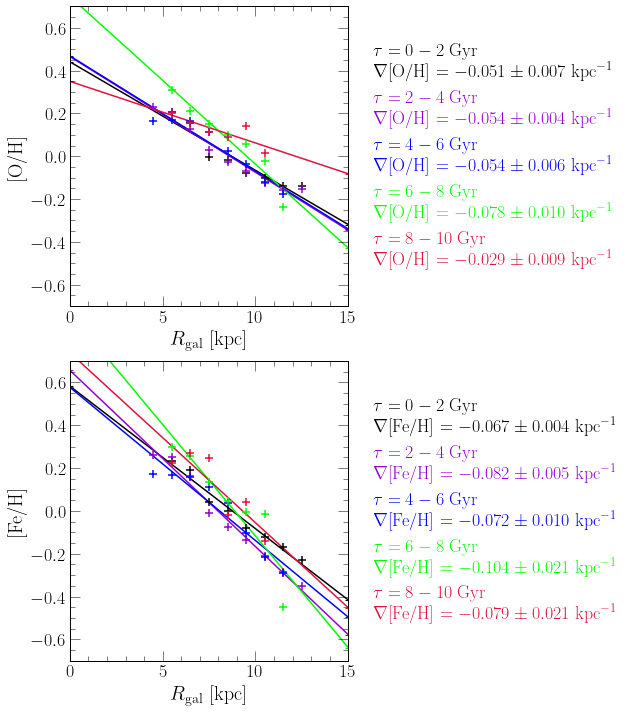

In [11]:
colors = ["black", "darkviolet", "blue", "lime", "crimson"]

fig = plt.figure(figsize = (9, 10))
axes = []
for i in range(2):
    axes.append(fig.add_subplot(211 + i))
    axes[i].set_xlabel(r"$R_\text{gal}$ [kpc]")
    axes[i].set_xlim([0, 15])
    axes[i].set_ylim([-0.7, 0.7])
axes[0].set_ylabel(r"[O/H]")
axes[1].set_ylabel(r"[Fe/H]")
# ax1.set_xlabel(r"$R_\text{gal}$ [kpc]")
# ax1.set_ylabel(r"[O/H]")
# ax1.set_xlim([0, 15])
# ax1.set_ylim([-0.7, 0.7])

filenames = ["./apogee/age_gradoh_skewnormfits.out", "./apogee/age_gradfeh_skewnormfits.out"]
for k in range(len(filenames)):
    raw = np.genfromtxt(filenames[k])
    for i in range(len(age_bins) - 1):
        fits = raw[i * (len(radial_bins) - 1) : (i + 1) * (len(radial_bins) - 1)]
        radii = []
        oh = []
        for j in range(len(fits)):
            if not any([np.isnan(_) for _ in fits[j][4:]]):
                radii.append((fits[j][2] + fits[j][3]) / 2)
                oh.append(mode_of_skewnorm(fits[j][4], fits[j][6], fits[j][8]))
            else: pass
        kwargs = {
            "c": named_colors()[colors[i]],
            "marker": markers()['plus'],
            "zorder": 100
        }
        axes[k].scatter(radii, oh, s = 50, **kwargs)
        regression = linregress(radii, oh)
        print("Age: %d - %d Gyr" % (age_bins[i], age_bins[i + 1]))
        print("Slope: %.3f +/- %.3f" % (regression.slope, regression.stderr))
        print("Intercept: %.3f +/- %.3f" % (regression.intercept, regression.intercept_stderr))
        print("==================================")
        bestfit = line(regression.slope, regression.intercept)
        elem = ["O", "Fe"][k]
        kwargs["label"] = r"$\tau = %d - %d$ Gyr" "\n" r"$\nabla$[%s/H] = $%.3f \pm %.3f$ kpc$^{-1}$" % (
            age_bins[i], age_bins[i + 1], elem, regression.slope, regression.stderr)
        kwargs["zorder"] = 0
        axes[k].plot(axes[k].get_xlim(), [bestfit(_) for _ in axes[k].get_xlim()], **kwargs)
    
for i in range(len(filenames)):
    kwargs = {
        "loc": mpl_loc("center left"),
        "bbox_to_anchor": (1.01, 0.50),
        "handlelength": 0,
        "ncol": 1
    }
    leg = axes[i].legend(**kwargs)
    fancy_legend(leg, colors)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./apogee/gradxh_fixedage.%s" % (ext), **kwargs)
plt.show()

In [19]:
def mode(values, bins):
    dist, _ = np.histogram(values, bins = bins)
    idxmax = dist.tolist().index(max(dist))
    return (bins[idxmax] + bins[idxmax + 1]) / 2

In [29]:
radial_bins = list(range(16))
age_bins = [0, 2, 4, 6, 8]
bins = np.linspace(-3, 2, 501)

def bootstrap_callable(values, **kwargs):
    return np.array([mode(values, bins)])

with open("./gradient_binned_by_age.out", 'w') as f:
    f.write("# COLUMNS:\n")
    f.write("# 0. min_age [Gyr]\n")
    f.write("# 1. max_age [Gyr]\n")
    f.write("# 2. min_radius [kpc]\n")
    f.write("# 3. max_radius [kpc]\n")
    n = 4
    for item in ["[Fe/H]", "[O/H]", "[O/Fe]"]:
        f.write("# %d. mode(%s)\n" % (n, item))
        f.write("# %d. err_mode(%s)_minus\n" % (n + 1, item))
        f.write("# %d. err_mode(%s)_plus\n" % (n + 2, item))
        n += 3
    for i in range(len(age_bins) - 1):
        subsample = sample.filter(
            "ASTRONN_AGE", ">=", age_bins[i]).filter(
            "ASTRONN_AGE", "<=", age_bins[i + 1]).filter(
            "FE_H", "<", 10).filter(
            "O_FE", "<", 10).filter(
            "O_H", "<", 10)
        for j in range(len(radial_bins) - 1):
            subsubsample = subsample.filter(
                "GALR", ">=", radial_bins[j]).filter(
                "GALR", "<=", radial_bins[j + 1])
            sys.stdout.write("\rage = %d - %d Gyr ; R = %d - %d kpc        " % (
                age_bins[i], age_bins[i + 1], radial_bins[j], radial_bins[j + 1]))
            f.write("%.3e\t%.3e\t%.3e\t%.3e\t" % (age_bins[i], age_bins[i + 1],
                radial_bins[j], radial_bins[j + 1]))
            for key in ["FE_H", "O_H", "O_FE"]:
                values = subsubsample[key]
                if len(values) >= 200:
                    mode_ = bootstrap_callable(values)
#                     print(mode_)
#                     bootstrap_ci = bootstrap((values,), bootstrap_callable, confidence_level = 0.68,
#                         method = "percentile", random_state = 1)
#                     minus_err = mode_ - bootstrap_ci.confidence_interval.low
#                     plus_err = bootstrap_ci.confidence_interval.high - mode_
                    err = np.std(values) / np.sqrt(len(values))
                    minus_err = plus_err = err / 2
                    f.write("%.3e\t%.3e\t%.3e\t" % (mode_, minus_err, plus_err))
                else:
                    f.write("nan\tnan\tnan\t")
            f.write("\n")
    sys.stdout.write("\n")

age = 6 - 8 Gyr ; R = 14 - 15 kpc        


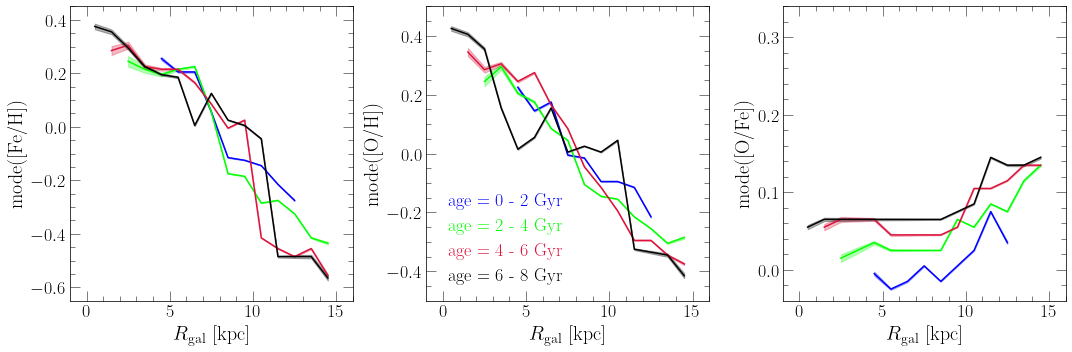

In [31]:
fig = plt.figure(figsize = (15, 5))
axes = []
for i in range(3):
    axes.append(fig.add_subplot(131 + i))
    axes[i].set_xlabel(r"$R_\text{gal}$ [kpc]")
    axes[i].set_xlim([-1, 16])
axes[0].set_ylabel("mode([Fe/H])")
axes[0].set_ylim([-0.65, 0.45])
axes[1].set_ylabel("mode([O/H])")
axes[1].set_ylim([-0.5, 0.5])
axes[2].set_ylabel("mode([O/Fe])")
axes[2].set_ylim([-0.04, 0.34])
axes[2].set_yticks([0, 0.1, 0.2, 0.3])

colors = ["blue", "lime", "crimson", "black"]
raw = np.genfromtxt("./gradient_binned_by_age.out")
n_age_bins = len(age_bins) - 1
n_rad_bins = len(radial_bins) - 1
for i in range(n_age_bins):
    measurements = raw[i * n_rad_bins : (i + 1) * n_rad_bins]
    radii = [(a + b) / 2 for a, b in zip(measurements[:,2], measurements[:,3])]
    feh = measurements[:,4]
    feh_lower = [a - b for a, b in zip(feh, measurements[:,5])]
    feh_upper = [a + b for a, b in zip(feh, measurements[:,6])]
    oh = measurements[:,7]
    oh_lower = [a - b for a, b in zip(oh, measurements[:,8])]
    oh_upper = [a + b for a, b in zip(oh, measurements[:,9])]
    ofe = measurements[:,10]
    ofe_lower = [a - b for a, b in zip(ofe, measurements[:,11])]
    ofe_upper = [a + b for a, b in zip(ofe, measurements[:,12])]
    kwargs = {
        "c": named_colors()[colors[i]],
        "label": "age = %d - %d Gyr" % (measurements[0][0], measurements[0][1])
    }
    axes[0].plot(radii, feh, **kwargs)
    axes[1].plot(radii, oh, **kwargs)
    axes[2].plot(radii, ofe, **kwargs)
    kwargs["color"] = kwargs["c"]
    del kwargs["c"]
    kwargs["label"] = None
    kwargs["alpha"] = 0.3
    axes[0].fill_between(radii, feh_lower, feh_upper, **kwargs)
    axes[1].fill_between(radii, oh_lower, oh_upper, **kwargs)
    axes[2].fill_between(radii, ofe_lower, ofe_upper, **kwargs)

kwargs = {
    "loc": mpl_loc("lower left"),
    "handlelength": 0
}
leg = axes[1].legend(**kwargs)
fancy_legend(leg, colors)

plt.tight_layout()
plt.show()

## The Abundance Gradient in Bins of Age

The above figure shows the mode [Fe/H] (left), [O/H] (middle), and [O/Fe] (right) as a function of radius in bins of age, color-coded according to the legend in the middle panel. Points are plotted along the lines if and only if there are $N \geq 200$ stars in the corresponding bin of radius and age.

Gradients in both [Fe/H] and [O/H] were largely established by $\tau \approx 8$ Gyr ago, with only marginal evolution in [O/H] between the $6 - 8$ Gyr and $4 - 6$ Gyr bins. As a consequence, there is also only marginal evolution in the [O/Fe] gradient with time.

Qualitatively, this lack of evolution in the observed abundance gradient suggests that the Galaxy achieved some chemical equilibrium $\sim$8 Gyr ago. This favors chemical evolution models in which the duration of star formation is much longer than the timescale to reach chemical equilibrium (i.e., $t \gg \tau_\text{eq}$). In another set of notes, I have demonstrated that the normalization of the gradient grows with time when $t \ll \tau_\text{eq}$. This realization could favor models with significant mass loading as a function of radius, unless there are other ways to produce an equilibrium abundance that strongly varies with radius.

In [4]:
radial_bins = list(range(16))
with open("./medianage_vs_r.out", 'w') as f:
    f.write("# radius [kpc]    median age [Gyr]    age_err_minus [Gyr]    age_err_plus [Gyr]\n")
    for i in range(len(radial_bins) - 1):
        subsample = sample.filter(
        "ASTRONN_AGE", ">=", 0).filter(
        "ASTRONN_AGE", "<=", 13.2).filter(
        "GALR", ">=", radial_bins[i]).filter(
        "GALR", "<=", radial_bins[i + 1])
        radius = (radial_bins[i] + radial_bins[i + 1]) / 2
        ages = (subsample["ASTRONN_AGE"],)
        med_age = np.median(ages)
        bootstrap_ci = bootstrap(ages, np.median, confidence_level = 0.68,
            method = "percentile", random_state = 1)
        f.write("%.3e\t%.3e\t%.3e\t%.3e\n" % (radius, med_age,
            med_age - bootstrap_ci.confidence_interval.low,
            bootstrap_ci.confidence_interval.high - med_age))
    f.close()

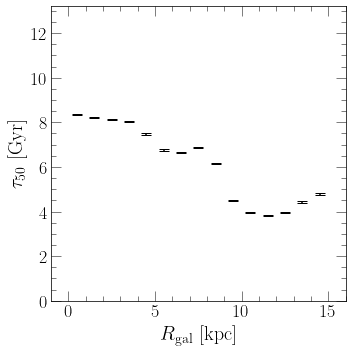

In [6]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$R_\text{gal}$ [kpc]")
ax.set_ylabel(r"$\tau_{50}$ [Gyr]")
ax.set_xlim([-1, 16])
ax.set_ylim([0, 13.2])

with open("./medianage_vs_r.out", 'r') as f:
    while True:
        line = f.readline()
        if line == "": break
        if line[0] == "#": continue
        line = [float(_) for _ in line.split()]
        ax.errorbar(line[0], line[1], c = named_colors()["black"],
            yerr = [[line[2]], [line[3]]])
    f.close()

plt.tight_layout()
plt.show()